# PyTorch mutual information neural estimation tests

Trivial tests with multivariate Gaussian and uniform distribution

In [1]:
import sys
sys.path.append("../python")

In [2]:
import numpy as np

In [3]:
import torch
import torchvision
import torchkld

In [4]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")

Device: cuda:1
Devices count: 2


In [5]:
from tqdm import tqdm, trange

In [6]:
from misc.modules import *
from misc.utils import *
from misc.plots import *

In [7]:
config = {}

## Dataset

Dataset and dataloader

In [8]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [9]:
config["dataset"] = "MNIST"
#config["dataset"] = "CIFAR10"
config["n_copies"] = 2
config["n_classes"] = 10
config["mutual_information"] = config["n_copies"] * np.log(config["n_classes"])
aggregate = lambda x_list: torch.cat(x_list, dim=1)

train_dataset = getattr(torchvision.datasets, config["dataset"])(root="./.cache", download=True, transform=image_transform)
test_dataset  = getattr(torchvision.datasets, config["dataset"])(root="./.cache", download=True, transform=image_transform, train=False)

In [10]:
batch_size = 512

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

## Estimating MI

Model

In [11]:
class MNIST_T_network(torchkld.mutual_information.MINE):
    def __init__(self, X_channels: int=1, Y_channels: int=1) -> None:
        super().__init__()
        
        self.conv2d_1 = torch.nn.Conv2d(X_channels + Y_channels, 64, 3, padding='same')
        self.conv2d_2 = torch.nn.Conv2d(64, 128, 3, padding='same')
        self.conv2d_3 = torch.nn.Conv2d(128, 128, 3, padding='same')

        self.linear_1 = torch.nn.Linear(128*7*7, 128)
        self.linear_2 = torch.nn.Linear(128, 1)

        self.pooling = torch.nn.AvgPool2d(2)
        self.activation = torch.nn.LeakyReLU()

    def forward(self, x: torch.Tensor, y: torch.Tensor, marginalize: bool=False) -> torch.Tensor:
        x, y = super().forward(x, y, marginalize)
        
        z = torch.cat([x, y], axis=1)

        z = self.conv2d_1(z)
        z = self.pooling(z)
        z = self.activation(z)

        z = self.conv2d_2(z)
        z = self.pooling(z)
        z = self.activation(z)

        z = self.conv2d_3(z)
        z = self.activation(z)

        z = z.flatten(start_dim=1)
        
        z = self.linear_1(z)
        z = self.activation(z)

        z = self.linear_2(z)

        return z

In [12]:
model = MNIST_T_network(config["n_copies"], config["n_copies"]).to(device)
total_parameters = sum(parameter.numel() for parameter in model.parameters())
print(f"Total parameters: {total_parameters}")

Total parameters: 1026881


Loss

In [13]:
# Loss.
biased = False
ema_multiplier = 1.0e-2
marginalize = "permute" # "permute", "product"

losses = {
    "DonskerVaradhan": torchkld.loss.DonskerVaradhanLoss(biased=biased, ema_multiplier=ema_multiplier),
    "NWJ": torchkld.loss.NWJLoss(),
    "Nishiyama": torchkld.loss.NishiyamaLoss(),
    "InfoNCE": torchkld.loss.InfoNCELoss(),
}

loss_name = "DonskerVaradhan"
loss = losses[loss_name]

Optimizer

In [14]:
learning_rate = 1.0e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Training

In [15]:
import matplotlib
from matplotlib import pyplot as plt

In [16]:
# Number of epochs used to average the estimate.
average_epochs = 20

In [17]:
def permute_pairs_preserve_labels(
    samples: torch.Tensor,
    labels: torch.Tensor
) -> tuple[torch.Tensor, torch.Tensor]:
    unique_labels = labels.unique()

    subsets_indices = []
    permuted_subsets_indices = []
    for label in unique_labels:
        subset_indices = (labels == label).nonzero().squeeze(dim=1)
        subsets_indices.append(subset_indices)
        permuted_subsets_indices.append(subset_indices[torch.randperm(subset_indices.shape[0])])

    indices = torch.cat(subsets_indices, axis=0)
    permuted_indices = torch.cat(permuted_subsets_indices, axis=0)

    return samples[indices], samples[permuted_indices]

In [24]:
def permute_aggregate(
    samples: torch.Tensor,
    labels: torch.Tensor,
    aggregate=lambda x_list : torch.cat(x_list, dim=1),
    n_copies: int=1
) -> tuple[torch.Tensor, torch.Tensor]:

    x_1_list = []
    x_2_list = []
    for index in range(config["n_copies"]):
        x_1, x_2 = permute_pairs_preserve_labels(samples, labels)
        
        permutation = torch.randperm(x_1.shape[0])
        x_1_list.append(x_1[permutation])
        x_2_list.append(x_2[permutation])

    return aggregate(x_1_list), aggregate(x_2_list)

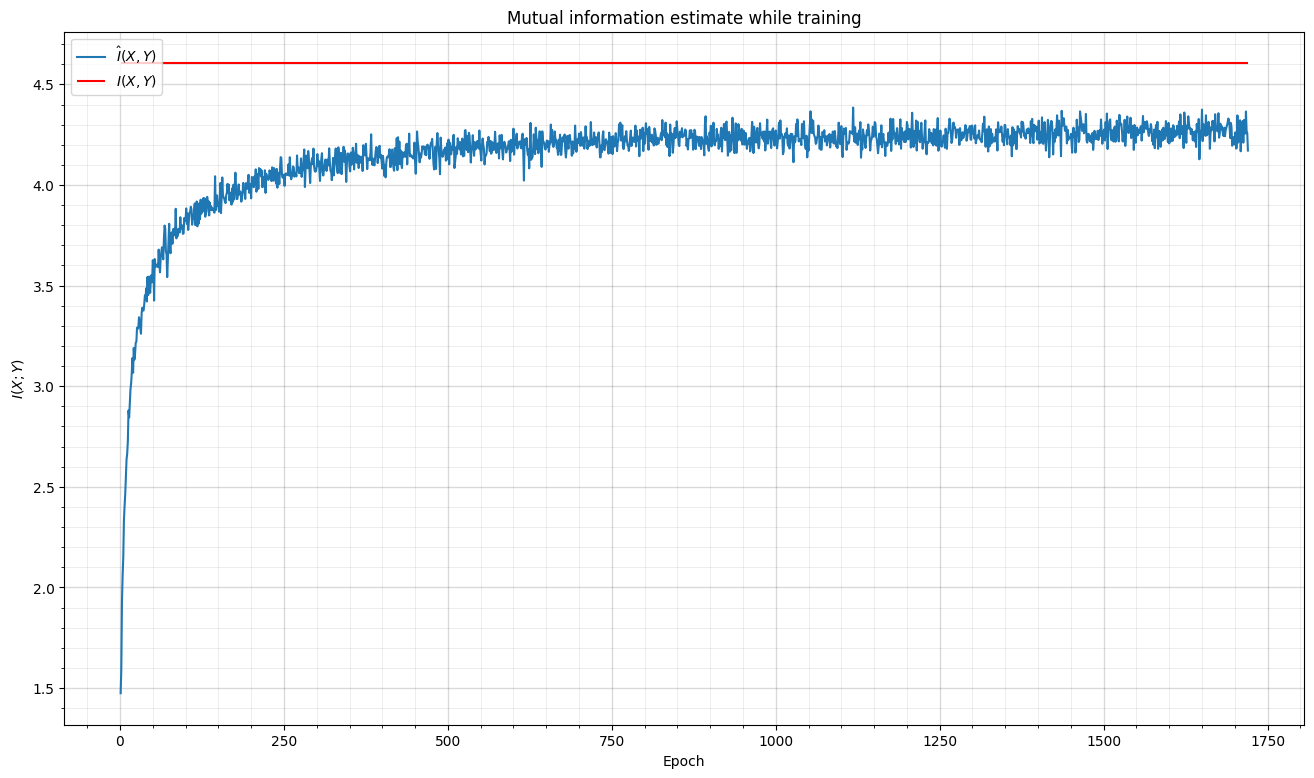

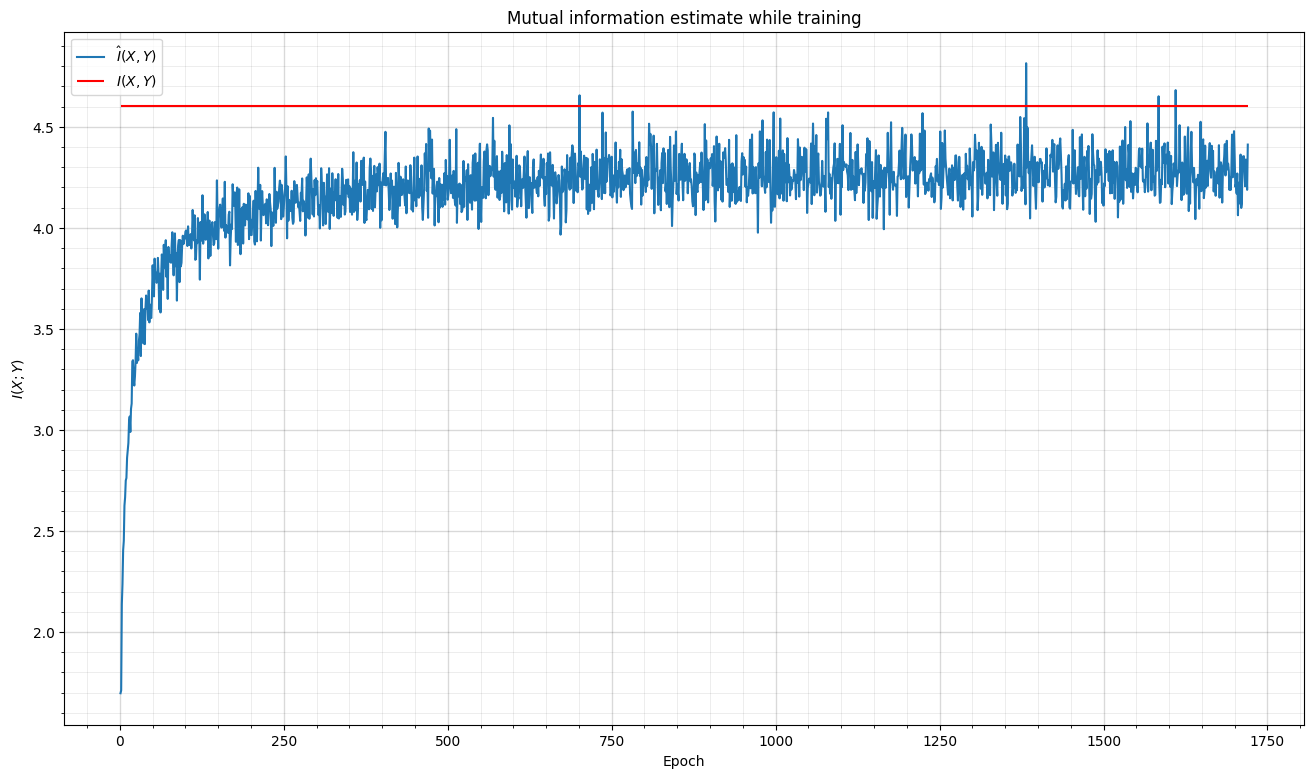

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1720/2000 [23:46:31<3:34:13, 45.91s/it]

Current estimate: 4.41
Running median: 4.22


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1721/2000 [23:47:14<3:29:12, 44.99s/it]

In [ ]:
from collections import defaultdict
from IPython.display import clear_output
from tqdm import trange

n_epochs = 2000

history = defaultdict(list)
for epoch in trange(1, n_epochs + 1, mininterval=1):    
    # Training.
    for index, batch in enumerate(train_dataloader):
        x, y = batch
        batch_size = x.shape[0]

        x_1, x_2 = permute_aggregate(x, y, aggregate, config["n_copies"])
        
        optimizer.zero_grad()
        
        T_joined   = model(x_1.to(device), x_2.to(device))
        T_marginal = model(x_1.to(device), x_2.to(device), marginalize=marginalize)
        _loss = loss(T_joined, T_marginal)
        _loss.backward()
        
        optimizer.step()

    history["train_mutual_information"].append(model.get_mutual_information(train_dataloader, loss, device, marginalize=marginalize, transform=permute_aggregate))
    history["test_mutual_information"].append(model.get_mutual_information(test_dataloader, loss, device, marginalize=marginalize, transform=permute_aggregate))

    if epoch % 5 == 0:        
        clear_output(wait=True)
        plot_estimated_MI_trainig(config["mutual_information"], np.arange(1, epoch+1), history["train_mutual_information"])
        plot_estimated_MI_trainig(config["mutual_information"], np.arange(1, epoch+1), history["test_mutual_information"])
        print(f"Current estimate: {history['test_mutual_information'][-1]:.2f}")
        print(f"Running median: {np.median(history['test_mutual_information'][-average_epochs:]):.2f}")

### Saving the results

In [ ]:
parameters = {
    # Dataset.
    "dataset_type": dataset_type,
    "mutual_information": mutual_information,

    # Model.
    "inner_dim": inner_dim,

    # Loss.
    "loss_name": loss_name,
    "biased": biased,
    "ema_multiplier": ema_multiplier,

    # Training.
    "n_samples": n_samples,
    "batch_size": batch_size,
    "n_epochs": n_epochs,
    "learning_rate": learning_rate,

    # Saving the results.
    "average_epochs": average_epochs,
}

In [ ]:
from datetime import datetime

experiment_name = f"{dataset_type}_{dimension}_{mutual_information:.1f}_{n_samples}__{datetime.now().strftime('%d-%b-%Y_%H:%M:%S')}"
print(experiment_name)

In [ ]:
import os
from pathlib import Path

data_path = Path(os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), "../../data/synthetic")))
experiment_path = data_path / f"{dataset_type}" / loss_name / experiment_name

In [ ]:
save_results(history, parameters, experiment_path, average_epochs=average_epochs)